# Tarea N°2 - Máquinas de Aprendizaje - ILI393
### Martín Villanueva A.

## Introducción

En la siguiente tarea, se desarrollaran e implementaran algunos de los más clásicos algoritmos de clasificación, con el objetivo de comparar los distintos resultados y las ventajas e inconvenientes de cada uno de estos, testeando los resultados en dos datasets estándar. En cuanto a la implementación de los algoritmos y a la estructura del informe es importante hacer notar algunas cosas:
- Todos fueron programados siguiendo el estandar de scikit-learn con la estructura [estimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html), de modo que se pudiesen ocupar algunas funcionalidades como [GridSearch](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) (para la selección de los mejores parámetros) en todos los algoritmos por igual, tal como si fuesen implementaciones propias de la librería.
- Para la selección de parámetros (en caso de que el clasificador requiera) se realiza 5-fold cross validation. La métrica ocupada para elegir el mejor parámetro es el _accuracy_, que es el 1-*error_rate*.
- Para cada dataset, se generaron 20 subdatasets de entrenamiento y test. Sin embargo sólo se muestran los resultado particulares de los dataset 2 y 15 (elegidos aleatoriamente). En caso de que se quieran ver más resultados, indicarlo en el parámetro _show_ de la función *solve_clf*.
- Para la selección de la forma en que se trabajan los datos (puros, rescalados o normalizados) se realizan pruebas de concepto previas para cada algoritmo, y se elige la que obtiene mejores resultados. De todos modos esta puede modificarse en el parámetro *data_func* de la función *solve_clf*.

## Parte 1 - Evaluación de Créditos

### 1) Linear Discriminant Analysis

**Comentarios de Implementación:**

- Por simplicidad se implementó la versión que funciona sólo para dos clases.
- Se evita el cálculo explícito de inversas ocupando _np.lingalg.solve_ en su defecto.
- Para facilitar el trabajo de clasificación, en el proceso de fit sólo se computan los $(w_1, w_2)$ y $(b_1, b_2)$ de las funciones discriminantes lineales $\delta_1(x) = w_1^T x + b1$ y $\delta_2(x) = w_2^T x + b2$. De este modo la clasificación se realiza con una sola comparación y eficientemente.

Se muestran a continuación los resultados obtenidos sobre los datasets, junto a un resumen de los errores de entrenamiento y test.

##############################################################
Dataset: 2
Training error: 0.0222222222222
Testing error: 0.0666666666667
##############################################################


##############################################################
Dataset: 15
Training error: 0.0555555555556
Testing error: 0.0666666666667
##############################################################




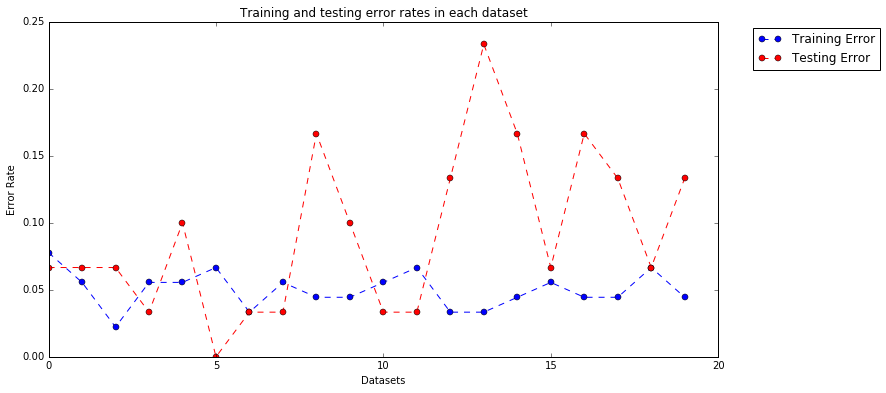

In [112]:
lda = LDA()
lda_tr_err, lda_ts_err = solve_clf(lda, 'credit', data_func=None, show=[2,15])

### 2) Estimación alternativa de parámetros en LDA

**Comentarios de Implementación:**

- Como forma alternativa de estimar los parámetros se escogió una variación de la media intercuartílica, que es la media de los valores entre los percentiles 10 y 90. Esto tiene como fin tratar de arreglar en cierta medida la sensibilidad de la media a los outliers, y así tener una estimación más robusta de esta. Producto de esta modificación la matriz de covarianza _compartida_ también se ve modificada, no así las probabilidades por clase que se siguen computando como la probabilidad empírica.

Se muestran a continuación los resultados obtenidos sobre los datasets, junto a un resumen de los errores de entrenamiento y test, con la modificación propuesta.

##############################################################
Dataset: 2
Training error: 0.0444444444444
Testing error: 0.1
##############################################################


##############################################################
Dataset: 15
Training error: 0.0666666666667
Testing error: 0.0666666666667
##############################################################




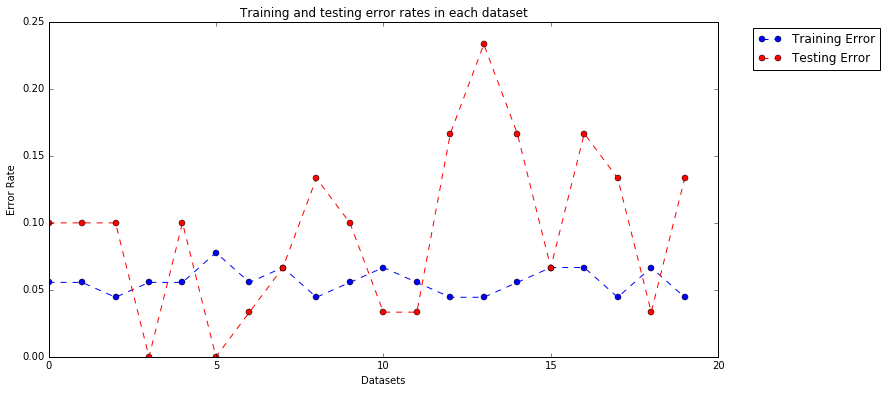

In [113]:
mlda = LDA(alternative=True)
mlda_tr_err, mlda_ts_err = solve_clf(mlda, 'credit', data_func=None, show=[2,15])

Para visualizar más facilmente las diferencias, se muestran a continuación gráficos de los errores de entrenamiento y test en conjunto para ambos métodos. Al respecto se puede decir que:

- Para los errores de entrenamiento, en general la forma estandar de LDA tiende a comportarse mejor que con la mejora propuesta.
- Sin embargo para los errores de testing ambos métodos tienen un desempeño similar, pero la forma modificada de LDA logra levemenente mejores resultados en algunos dataset.

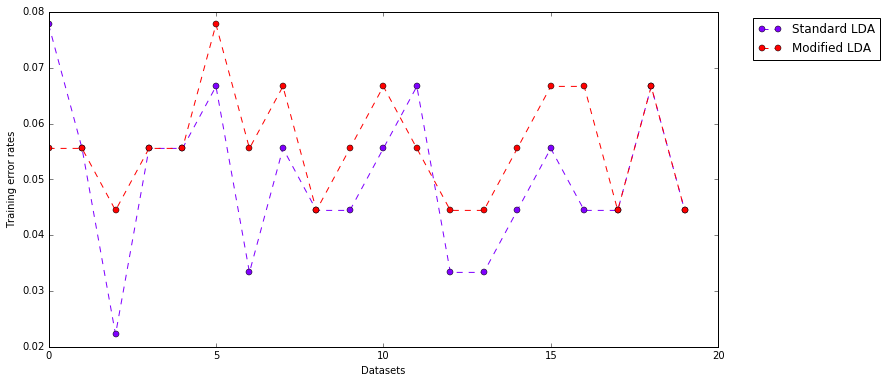

In [114]:
comparative_plot([lda_tr_err, mlda_tr_err],['Standard LDA', 'Modified LDA'], err_type='Training')

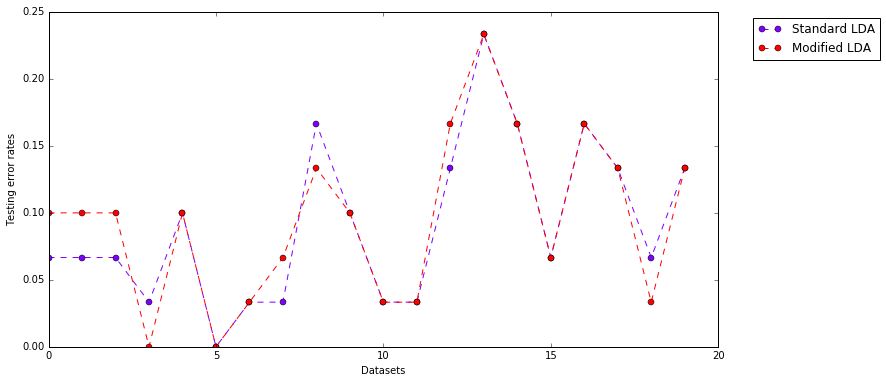

In [115]:
comparative_plot([lda_ts_err, mlda_ts_err],['Standard LDA', 'Modified LDA'], err_type='Testing')

### 3) Naive Bayes

** Comentarios de Implementación:**

- Las features que son discretizadas en cada dataset, son las que se indican en el parámetro _features_ del estimador Naive Bayes. En el caso del dataset credit, se discretizan todas las features menos la cuarta (que es binaria). Algunas de las features discretizadas son en efecto discretas, pero varían en un rango lo suficientemente extenso de modo que el mapeo a los distintos rangos no afecta (e incluso mejora) los resultados.
- La implementación intenta ser vectorizada en el mayor grado posible haciendo uso de _NumPy_.
- Para el cálculo de las probabilidades condicionales de las features $P(x^{(i)} | y=k)$, se ocupa Laplace Smoothing para sobrellevar el problema de los casos en donde existe frecuencia cero.

### 4) Métodos de discretización en Naive Bayes

Los tres métodos de discretización utilizados se describen a continuación:

- [Equal Width Discretization (EWD)][1]: Consiste en generar una partición de k intervalos equiespaciados entre el valor mínimo y máximo de cada una de las features. Luego cada uno de los datos debe mapearse a uno de los k posibles intervalos.
- [Equal Frequency Discretization (EFD)][1]: Consiste en generar una partición de k intervalos entre el valor mínimo y máximo de cada una de las features, de modo que cada intervalo tenga en lo posible la misma cantidad de valores. Este método es mejor contra outliers, pues en el caso anterior si existe un valor máximo muy alto y el resto de los datos son bajos, entonces se crearán muchos intervalos sin ningún dato.
- [Gauss Naive Bayes][2]: Este no es precisamente un método de discretización, pues no mapea los datos continuos a un intervalo como los enfoques anteriores. Por el contrario, este computa la probabilidad $\displaystyle P(x^{(i)} | y=c)=\frac{1}{\sqrt{2\pi\sigma^2_c}}\,e^{ -\frac{(x^{(i)}-\mu_c)^2}{2\sigma^2_c} }$ para datos continuos asumiendo una distribución normal en cada caso. Para esto estima la media y varianza de cada feature en base al training set. Este es un enfoque muy utilizado cuando se debe trabajar con datos continuos, y por eso se decidió incluirlo.

[1]: http://www.csse.monash.edu.au/~webb/Files/YangWebb02a.pdf
[2]: http://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes

#### Equal Width Discretization (EWD)

In [10]:
#number of intervals to try on both, EWD and EFD (through cross validation)
nb_params = {'nbins':np.array([4,8,12,16,20])}

##############################################################
Dataset: 2
Best parameter: {'nbins': 8}
CV scores:
mean: 0.80000, std: 0.05730, params: {'nbins': 4}
mean: 0.84444, std: 0.02309, params: {'nbins': 8}
mean: 0.83333, std: 0.05908, params: {'nbins': 12}
mean: 0.81111, std: 0.03228, params: {'nbins': 16}
mean: 0.74444, std: 0.06730, params: {'nbins': 20}
Training error: 0.0555555555556
Testing error: 0.266666666667
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nbins': 12}
CV scores:
mean: 0.77778, std: 0.07359, params: {'nbins': 4}
mean: 0.75556, std: 0.06588, params: {'nbins': 8}
mean: 0.81111, std: 0.07558, params: {'nbins': 12}
mean: 0.78889, std: 0.03596, params: {'nbins': 16}
mean: 0.78889, std: 0.04928, params: {'nbins': 20}
Training error: 0.0444444444444
Testing error: 0.2
##############################################################




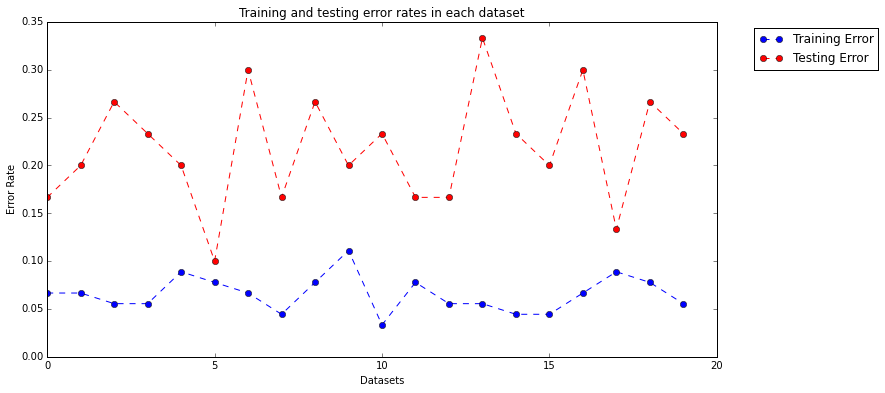

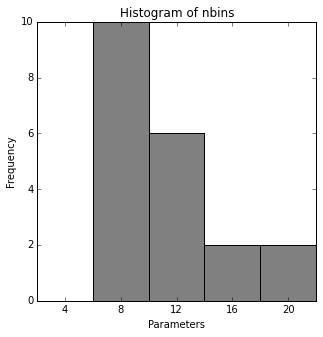

In [11]:
nb = NB(features=[0,1,2,3,5], disc_type='EWD')
ewd_nb_tr_err, ewd_nb_ts_err = solve_clf(nb, 'credit', params=nb_params, show=[2,15])

#### Equal Frequency Discretization (EWD)

##############################################################
Dataset: 2
Best parameter: {'nbins': 4}
CV scores:
mean: 0.84444, std: 0.08725, params: {'nbins': 4}
mean: 0.78889, std: 0.05739, params: {'nbins': 8}
mean: 0.73333, std: 0.03805, params: {'nbins': 12}
mean: 0.74444, std: 0.06386, params: {'nbins': 16}
mean: 0.66667, std: 0.12271, params: {'nbins': 20}
Training error: 0.0444444444444
Testing error: 0.233333333333
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nbins': 4}
CV scores:
mean: 0.82222, std: 0.10460, params: {'nbins': 4}
mean: 0.74444, std: 0.03511, params: {'nbins': 8}
mean: 0.65556, std: 0.09513, params: {'nbins': 12}
mean: 0.76667, std: 0.12044, params: {'nbins': 16}
mean: 0.76667, std: 0.09995, params: {'nbins': 20}
Training error: 0.0444444444444
Testing error: 0.233333333333
##############################################################




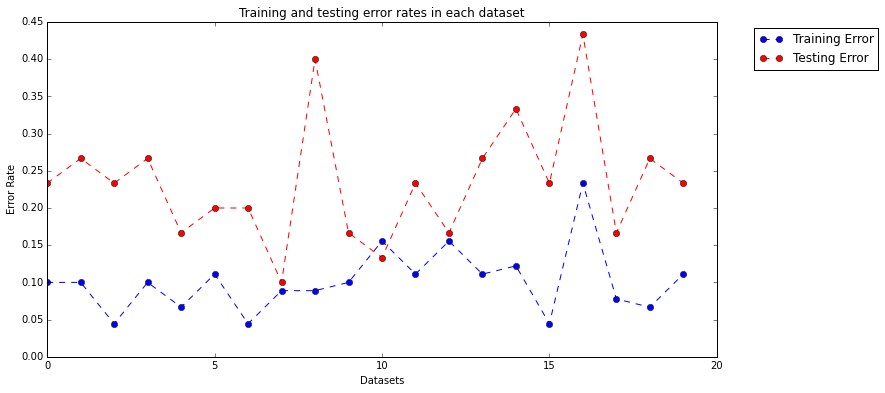

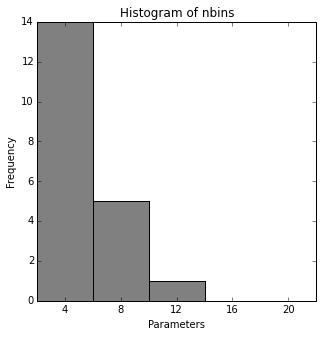

In [12]:
nb = NB(features=[0,1,2,3,5], disc_type='EFD')
efd_nb_tr_err, efd_nb_ts_err = solve_clf(nb, 'credit', params=nb_params, show=[2,15])

#### Gaussian Naive Bayes

##############################################################
Dataset: 2
Training error: 0.155555555556
Testing error: 0.233333333333
##############################################################


##############################################################
Dataset: 15
Training error: 0.188888888889
Testing error: 0.2
##############################################################




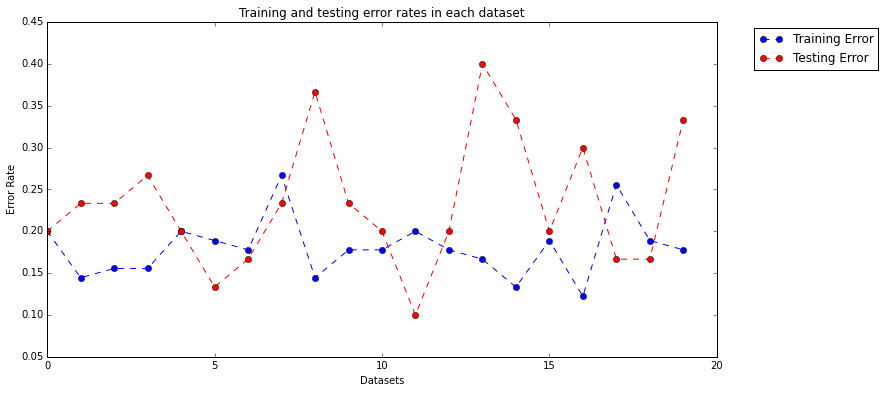

In [13]:
nb = NB(features=[0,1,2,3,5], disc_type='Gauss')
gs_nb_tr_err, gs_nb_ts_err = solve_clf(nb, 'credit', show=[2,15])

#### Comparación de los enfoques de discretización

A continuación se resumen los resultados de training y testing set para los tres métodos propuestos. Al respecto se puede decir lo siguiente:

- EWD y EFD obtienen muchos mejores errores de training que la contraparte de Gauss. Sucede de manera similar para los conjuntos de testing. Esto puede deberse al abuso que se hace en la suposición de distribución normal de cada feature, sin realizar un análisis previo de la forma en que se distribuyen los datos.
- EFD se comporta similar a EWD, pero para algunos datasets presenta errores de entrenamiento y test muy altos.
- El que tiene mejor desempeño en general es EWD.
- Del análisis de los histogramas para EWD y EFD se ve que EWD tiene mejor generalización con una cantidad de intervalos superior a los que tiene EFD.

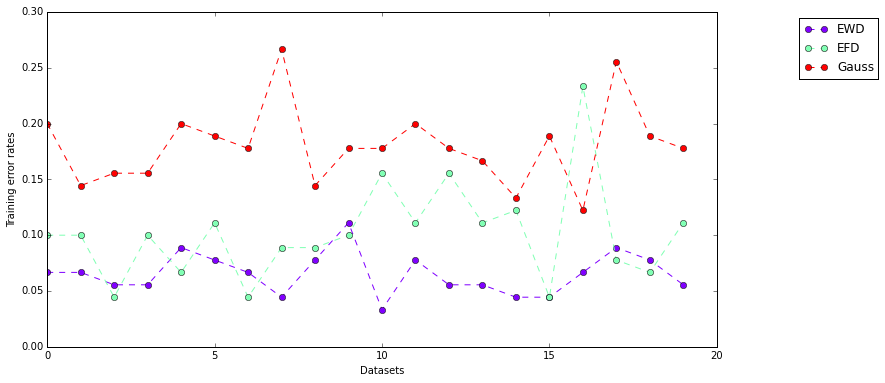

In [14]:
errors = [ewd_nb_tr_err, efd_nb_tr_err, gs_nb_tr_err]
labels = ['EWD', 'EFD', 'Gauss']
comparative_plot(errors, labels, err_type='Training')

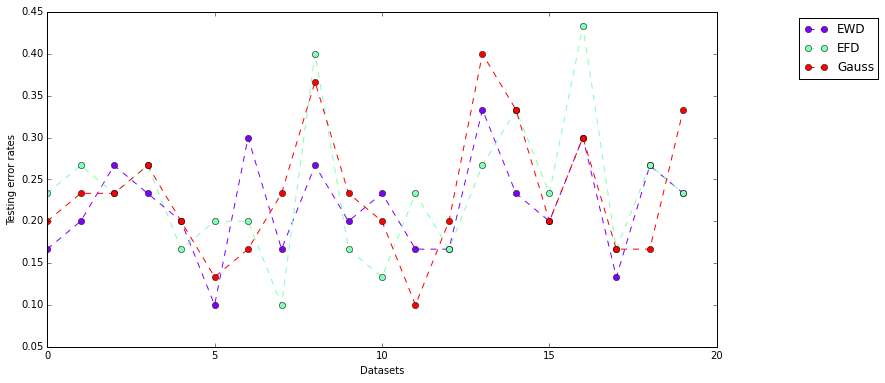

In [15]:
errors = [ewd_nb_ts_err, efd_nb_ts_err, gs_nb_ts_err]
labels = ['EWD', 'EFD', 'Gauss']
comparative_plot(errors, labels, err_type='Testing')

### 5) Perceptrón Primal

**Comentarios de Implementación:**

- Como criterio de parada se tiene tres posibilidades. 1) Número máximo de iteraciones, configurado en 100000. 2) Si el error de clasificación es 0, entonces el algoritmo se detiene. Vale decir, si se encuentra el hiperplano que separa perfectamente la data. 3) Si el error rate no cambia en un cantidad _tol_ de iteraciones, entonces debe detenerse. Esto pasa cuando se llega a un punto, en donde todas las variaciones que se le hacen al hiperplano generan la misma cantidad de datos mal clasificados.
- Para realizar predicciones se ve el signo de la función de margen funcional.

In [124]:
#parameters to try on primal perceptron
pp_params = {'eta':np.linspace(1e0, 1e2, 5, endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'eta': 1.0}
CV scores:
mean: 0.95556, std: 0.05303, params: {'eta': 1.0}
mean: 0.95556, std: 0.05303, params: {'eta': 25.75}
mean: 0.95556, std: 0.05303, params: {'eta': 50.5}
mean: 0.95556, std: 0.05303, params: {'eta': 75.25}
mean: 0.95556, std: 0.05303, params: {'eta': 100.0}
Training error: 0.0
Testing error: 0.133333333333
##############################################################


##############################################################
Dataset: 15
Best parameter: {'eta': 1.0}
CV scores:
mean: 0.92222, std: 0.07555, params: {'eta': 1.0}
mean: 0.92222, std: 0.07555, params: {'eta': 25.75}
mean: 0.92222, std: 0.07555, params: {'eta': 50.5}
mean: 0.92222, std: 0.07555, params: {'eta': 75.25}
mean: 0.92222, std: 0.07555, params: {'eta': 100.0}
Training error: 0.0444444444444
Testing error: 0.233333333333
##############################################################




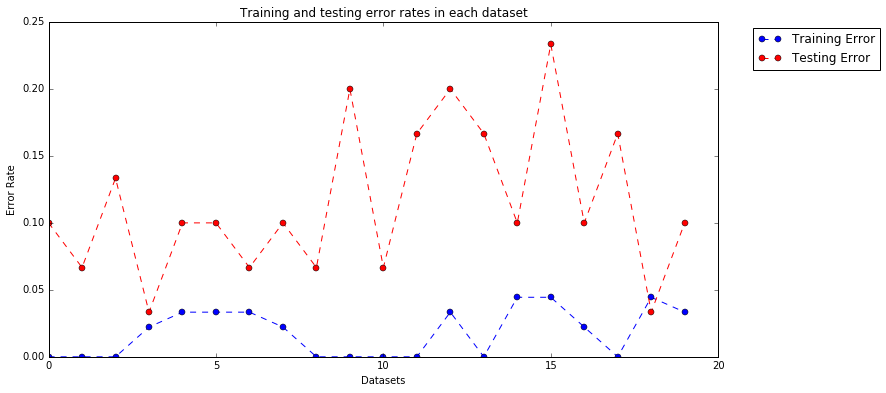

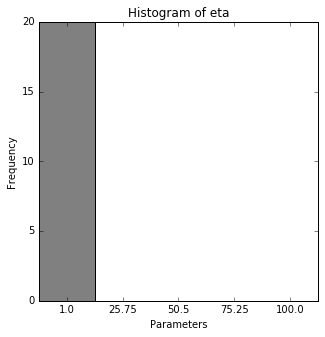

In [125]:
pp = PP()
pp_tr_err, pp_ts_err = solve_clf(pp, 'credit', params=pp_params, data_func=normalize, show=[2,15])

Acerca de los resultados obtenidos:
- En varios datasets el algoritmo del perceptrón primal logra encontrar el hiperplano separador perfecto para el training set, y por lo general el error de entrenamiento es muy bajo (síntoma de overfitting).
- El error de testing es alto comparado al de training para algunos datasets, pero bajo para otros. Se puede decir que la generalización que produce este algoritmo es un tanto aleatoria, en el sentido de que sólo intenta dar con un hiperplano separador, pero no se preocupa de las propiedades separadoras de este.
- Como puede verse del histograma anterior y de los resultados sobre los datasets, el valor de $\eta$ no influye en los resultados, es decir, cada $\eta$ obtiene los mismos scores para cada fold en los distintos datasets (se elige siempre $\eta=1$ pues es el primero en la lista). Esto tiene bastante sentido si se analiza las reglas de actualización:

$$ w_{p+1} \leftarrow w_{p} + \eta y_m x_m \ \ \ \text{y} \ \ \ \ b_{p+1} \leftarrow b_p + \eta y_m R^2 $$

entonces configurar un valor distinto de $\eta$ simplemente significa que el hiperplano separador $w^T x + b = 0$ quedará escalado por una constante $\eta' (w^T x + b) = 0 $, pero de todos modos sigue siendo el mismo hiperplano.

### 6) Nu-SVM con kernel lineal

Para la utilización de la SVM se decidió ocupar una $\nu$-SVM, debido a la facilidad de configuración del parámetro de holgura $\nu$ (rango acotado [0,1]) y a que este parámetro da a lugar a mayor interpretación que el parámetro C de una C-SVM. 

In [100]:
#parameters to try on Nu-SVM with linear kernel
lsvm_params = {'nu':np.linspace(0.05, 0.5, 5, endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'nu': 0.050000000000000003}
CV scores:
mean: 0.95556, std: 0.03972, params: {'nu': 0.050000000000000003}
mean: 0.94444, std: 0.06753, params: {'nu': 0.16250000000000001}
mean: 0.93333, std: 0.07955, params: {'nu': 0.27500000000000002}
mean: 0.93333, std: 0.06402, params: {'nu': 0.38750000000000001}
mean: 0.93333, std: 0.07955, params: {'nu': 0.5}
Training error: 0.0111111111111
Testing error: 0.2
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nu': 0.27500000000000002}
CV scores:
mean: 0.90000, std: 0.07344, params: {'nu': 0.050000000000000003}
mean: 0.92222, std: 0.05748, params: {'nu': 0.16250000000000001}
mean: 0.93333, std: 0.04008, params: {'nu': 0.27500000000000002}
mean: 0.92222, std: 0.05554, params: {'nu': 0.38750000000000001}
mean: 0.90000, std: 0.04177, params: {'nu': 0.5}
Trai

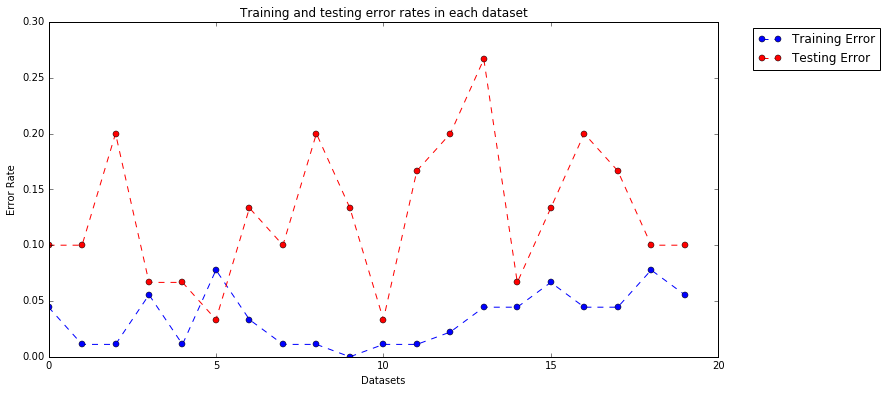

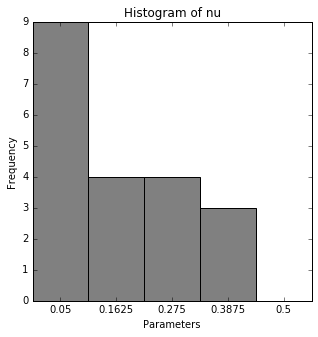

In [101]:
lsvm = svm.NuSVC(kernel='linear')
lsvm_tr_err, lsvm_ts_err = solve_clf(lsvm, 'credit', params=lsvm_params, data_func=normalize, show=[2,15])

Acerca de los resultados obtenidos:
    
- El hiperplano separador que genera obtiene bajos errores de training, pero no hay errores nulos como en el perceptrón primal. Esto es gracias al parámetro de holgura $\nu$, que nos indica cuánta holgura aceptar en errores de clasificación en favor de un resultado más generalizador.
- Como puede verse del histograma, en general se obtienen mejores resultados de validación con $\nu$'s bajos, esto quiere decir que no se requiere mucha holgura en los errores de clasificación para obtener el hiperplano separador de máximo margen , lo cual es bastante normal, pues como ya se sabe este dataset es fácilmente separable por planos.

### 7) Comparación de resultados

A continuación se comparan los errores de entrenamiento y test (en conjunto) para todos los algoritmos anteriores. Para aquellos algoritmos como LDA y Naive Bayes, se ocupan los modelos que generaron los mejores resultados.

#### Errores de Entrenamiento

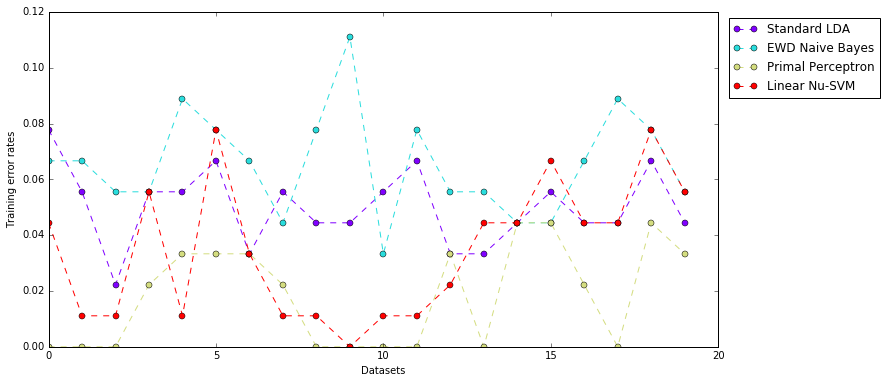

In [126]:
errors = [lda_tr_err, ewd_nb_tr_err, pp_tr_err, lsvm_tr_err]
labels = ['Standard LDA', 'EWD Naive Bayes', 'Primal Perceptron', 'Linear Nu-SVM']
comparative_plot(errors, labels, err_type='Training')

#### Errores de Test

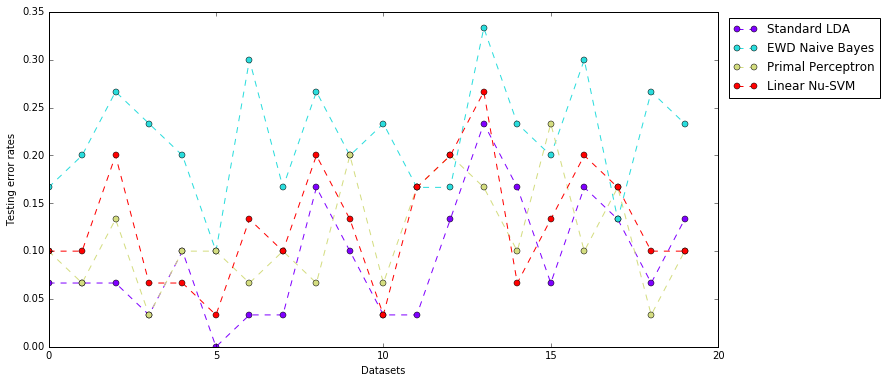

In [127]:
errors = [lda_ts_err, ewd_nb_ts_err, pp_ts_err, lsvm_ts_err]
labels = ['Standard LDA', 'EWD Naive Bayes', 'Primal Perceptron', 'Linear Nu-SVM']
comparative_plot(errors, labels, err_type='Testing')

Acerca de los resultados:

- Naive Bayes presenta claros problemas para generalizar en este dataset, puesto que presenta los errores de testing más alto entre los algoritmos.
- Aquellos que poseen los errores de entrenamiento más bajo son primal perceptrón y $\nu$-SVM.
- De manera un tanto sorpresiva el que obtiene en general los mejores errores de test es LDA (forma estándar), lo cual habla muy bien de su capacidad de generalización para este problema. El motivo de esto puede ser que los datos están cumpliendo los dos supuestos fuertes que plantea este enfoque: distribución gaussiana multivariada y matrices de covarianza iguales (o similares) entre las clases.
- Otro punto a favor de LDA, es que tuvo muy buenos resultados sin la necesidad de tener que setear algún hiperparametros por medio de cross-validation, tal como fue necesario en los otros.

## Parte 2 - Pima Indians Diabetes

### 1) Naive Bayes

En vista de que el método que tuvo mejor desempeño en el dataset anterior (_Equal Width Discretization_), se decide entonces ocuparlo aquí también para generar el modelo de predicción. Las features tomadas en cuenta para ser discretizada son aquellas que se ingresan en el arreglo _features_. Al igual que en el problema anterior, ciertas features a discretizar son ya discretas, pero se discretizan de todos modos pues varían en un rango relativamente alto. 

In [128]:
nb_params = {'nbins':np.array([10,14,18,22,26])}

##############################################################
Dataset: 2
Best parameter: {'nbins': 18}
CV scores:
mean: 0.71701, std: 0.03889, params: {'nbins': 10}
mean: 0.73264, std: 0.03985, params: {'nbins': 14}
mean: 0.73785, std: 0.02669, params: {'nbins': 18}
mean: 0.73611, std: 0.02812, params: {'nbins': 22}
mean: 0.72396, std: 0.02294, params: {'nbins': 26}
Training error: 0.206597222222
Testing error: 0.265625
##############################################################


##############################################################
Dataset: 15
Best parameter: {'nbins': 18}
CV scores:
mean: 0.73958, std: 0.03080, params: {'nbins': 10}
mean: 0.73958, std: 0.02130, params: {'nbins': 14}
mean: 0.75521, std: 0.01634, params: {'nbins': 18}
mean: 0.74826, std: 0.01842, params: {'nbins': 22}
mean: 0.73611, std: 0.01991, params: {'nbins': 26}
Training error: 0.230902777778
Testing error: 0.260416666667
##############################################################




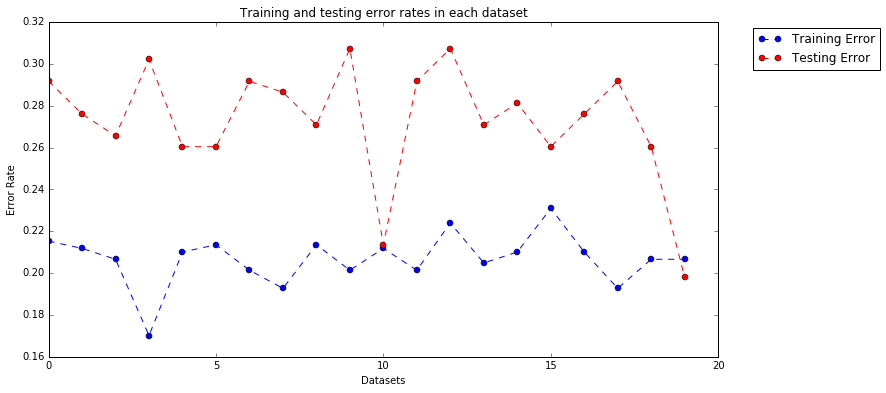

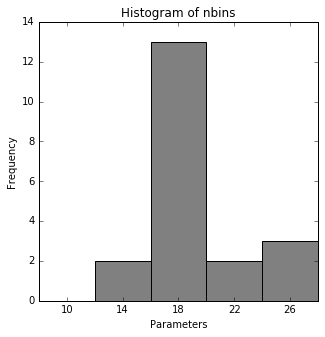

In [129]:
nb = NB(features=[0,1,2,3,4,5,6,7], disc_type='EWD')
nb_tr_err, nb_ts_err = solve_clf(nb, 'diabetes', params=nb_params, show=[2,15])

### 2) Perceptrón Dual con kernel gaussiano

**Comentarios de implementación:**

- La matriz con el cómputo _pairwise_ del kernel (Gram Matrix) se calcula inicialmente y una sola vez, para así acelerar el proceso de entrenamiento y predicción.
- El kernel utilizado es RBF Gaussiano: $K(x,y) = \exp(-\gamma \ ||x-y||^2)$
- Para la selección de parámetros se utiliza una grilla de 5x5, con los parámetros $\eta$ y $\nu$.
- Los criterios de salida son los mismo que para el perceptrón primal: Número máximo de iteraciones, cantidad de iteraciones que el error rate se mantiene sin cambiar y si el error rate se vuelve cero.

In [132]:
dp_params = {'eta':np.linspace(0.001,0.1,5,endpoint=True), 'gamma':np.linspace(0.5,2.,5,endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'eta': 0.075250000000000011, 'gamma': 0.875}
CV scores:
mean: 0.69271, std: 0.03123, params: {'eta': 0.001, 'gamma': 0.5}
mean: 0.69097, std: 0.03988, params: {'eta': 0.001, 'gamma': 0.875}
mean: 0.67882, std: 0.05271, params: {'eta': 0.001, 'gamma': 1.25}
mean: 0.66840, std: 0.03210, params: {'eta': 0.001, 'gamma': 1.625}
mean: 0.67708, std: 0.04826, params: {'eta': 0.001, 'gamma': 2.0}
mean: 0.70312, std: 0.04891, params: {'eta': 0.025750000000000002, 'gamma': 0.5}
mean: 0.68403, std: 0.05499, params: {'eta': 0.025750000000000002, 'gamma': 0.875}
mean: 0.67535, std: 0.06002, params: {'eta': 0.025750000000000002, 'gamma': 1.25}
mean: 0.66840, std: 0.06513, params: {'eta': 0.025750000000000002, 'gamma': 1.625}
mean: 0.68403, std: 0.06586, params: {'eta': 0.025750000000000002, 'gamma': 2.0}
mean: 0.69271, std: 0.04962, params: {'eta': 0.050500000000000003, 'gamma': 0.5}
mean: 0.68576, std: 0.03800

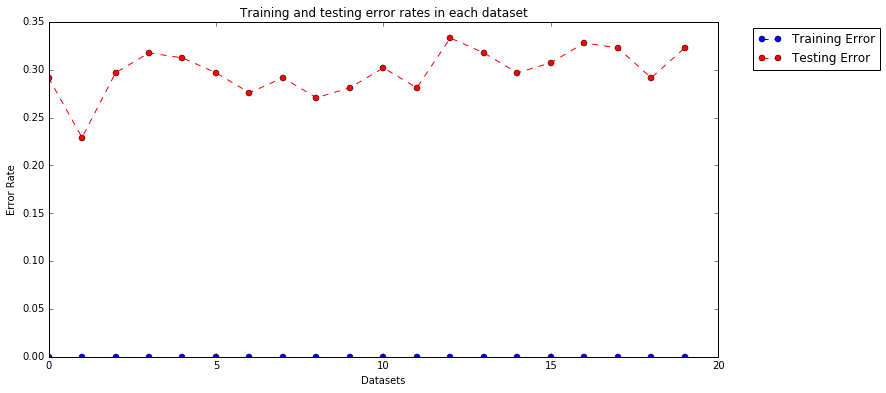

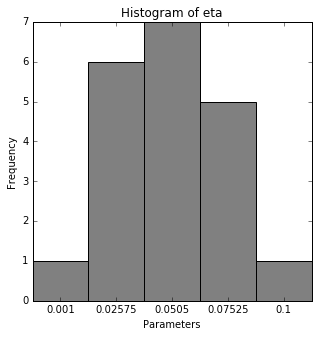

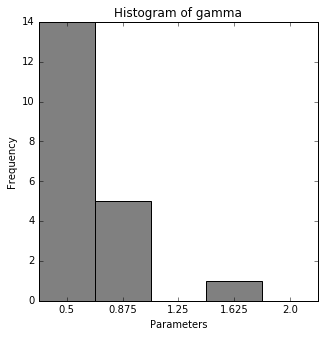

In [133]:
dp = DP()
dp_tr_err, dp_ts_err = solve_clf(dp, 'diabetes', params=dp_params, data_func=normalize, show=[2,15])

Acerca de los resultados:

- Este algoritmo es tremendamente efectivo en el training set, cumpliendo en todos los datasets con separar perfectamente la data (error rate = 0).
- Lo anterior es un efecto directo de la capacidad que tiene este método para aprender fronteras de decisión no lineales, gracias a que posee una métrica de similaridad no lineal. Sin embargo al no poseer un parámetro de holgura, cae en un sobreajuste de la data generando un modelo muy complejos.
- A diferencia de primal perceptrón, aquí el parámetro $\eta$ si determina el resultado a obtener.
- La tendencia es hacia parámetros $\gamma$ más bajos, esto es gaussianas "anchas". Esto quiere decir que al evaluar la métrica de similaridad, esta abarca un mayor radio para cada dato.

### 3) Nu-SVM con kernel gaussiano

De igual modo que para el problema anterior, se decide  utilizar una $\nu$-SVM, pero esta vez con un kernel gaussiano. Para la selección del mejor modelo se trabaja con una grilla de 5x5 con lo parámetros $\nu$ y $\gamma$. 

In [108]:
#parameters to try on kernel nu-SVM
ksvm_params = {'nu':np.linspace(0.25, 0.5, 5, endpoint=True), 'gamma':np.linspace(0.1,1.,5,endpoint=True)}

##############################################################
Dataset: 2
Best parameter: {'nu': 0.5, 'gamma': 0.10000000000000001}
CV scores:
mean: 0.69618, std: 0.04104, params: {'nu': 0.25, 'gamma': 0.10000000000000001}
mean: 0.72569, std: 0.02184, params: {'nu': 0.3125, 'gamma': 0.10000000000000001}
mean: 0.74826, std: 0.02239, params: {'nu': 0.375, 'gamma': 0.10000000000000001}
mean: 0.75521, std: 0.02620, params: {'nu': 0.4375, 'gamma': 0.10000000000000001}
mean: 0.76736, std: 0.03447, params: {'nu': 0.5, 'gamma': 0.10000000000000001}
mean: 0.70312, std: 0.03216, params: {'nu': 0.25, 'gamma': 0.32500000000000001}
mean: 0.71875, std: 0.03698, params: {'nu': 0.3125, 'gamma': 0.32500000000000001}
mean: 0.73090, std: 0.02866, params: {'nu': 0.375, 'gamma': 0.32500000000000001}
mean: 0.73090, std: 0.03217, params: {'nu': 0.4375, 'gamma': 0.32500000000000001}
mean: 0.74306, std: 0.01963, params: {'nu': 0.5, 'gamma': 0.32500000000000001}
mean: 0.70833, std: 0.04212, params: {'nu': 0.25,

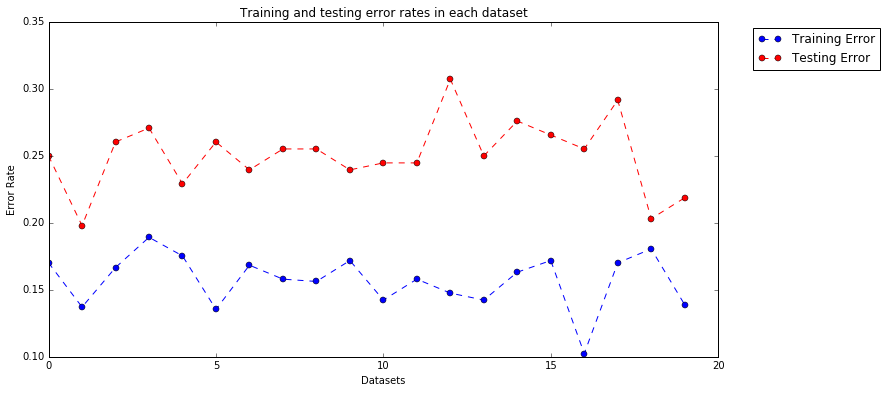

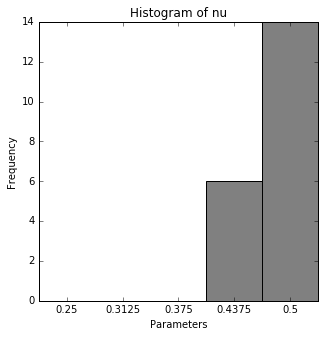

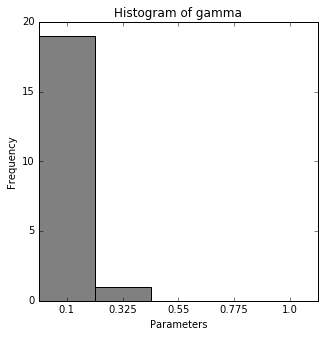

In [109]:
ksvm = svm.NuSVC(kernel='rbf')
ksvm_tr_err, ksvm_ts_err = solve_clf(ksvm, 'diabetes', params=ksvm_params, data_func=normalize, show=[2,15])

Acerca de los resultados:

- Pese a que este algoritmo también tiene la capacidad de aprender fronteras de decisión no lineales (por el kernel gaussiano), gracias al parámetro de holgura $\nu$ los errores de entrenamiento no son cero, y se obtienen por lo tanto un modelo que generaliza mejor en comparación con lo que se vió en el perceptrón dual.
- La tendencia de $\gamma$ es a valores pequeños (gaussianas anchas) al igual que en perceptrón dual.
- La tendencia de $\nu$ es a valores altos, sin embargo valores más altos producen divergencia en el algoritmo. El que $\nu$ tenga valores altos nos indíca que se le da holgura a cometer errores de clasificación en favor de obtener un hiperplano de mayor margen y más generalizador.

### 4) Comparación de resultados

A continuación se comparan los error de train y test en conjunto para todos los tres algoritmos anteriores.

#### Errores de entrenamiento

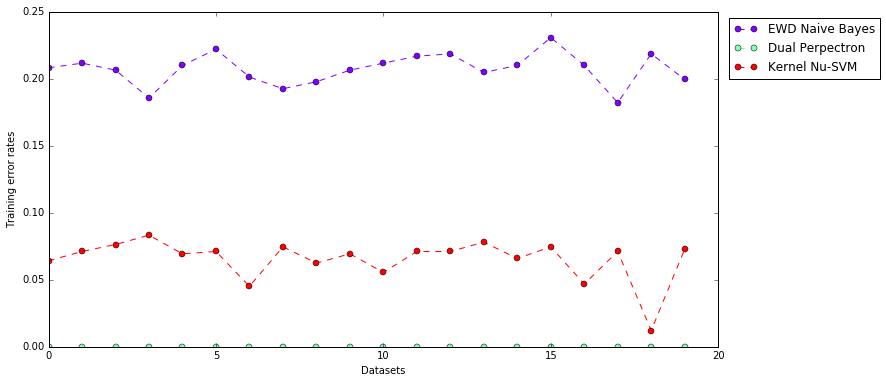

In [83]:
errors = [nb_tr_err, dp_tr_err, ksvm_tr_err]
labels = ['EWD Naive Bayes', 'Dual Perpectron', 'Kernel Nu-SVM']
comparative_plot(errors, labels, err_type='Training')

#### Errores de test

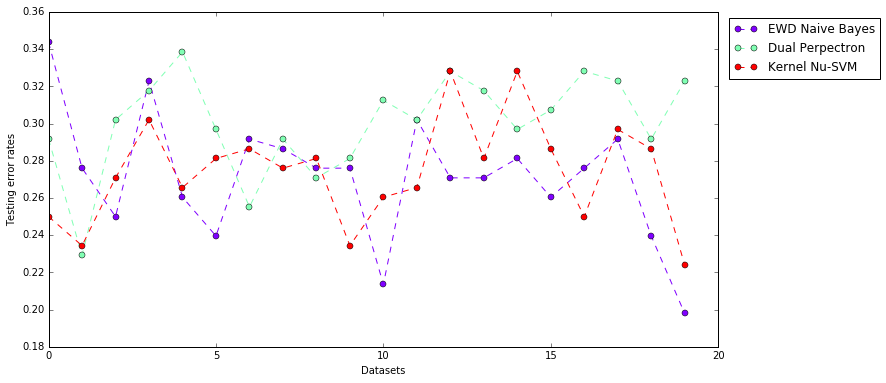

In [84]:
errors = [nb_ts_err, dp_ts_err, ksvm_ts_err]
labels = ['EWD Naive Bayes', 'Dual Perpectron', 'Kernel Nu-SVM']
comparative_plot(errors, labels, err_type='Testing')

Acerca de los resultados:

- Se puede ver claramente el overfitting que produce el perceptrón dual, respecto de la $\nu$-SVM quien está generalizando mucho mejor gracias a la capacidad de holgura.
- Pese a que Naive Bayes muestra errores de entrenamiento muy alto respecto de la competencia, su error de testing compite (y es mejor en algunos datasets) que el la $\nu$-SVM con kernel gaussiano. Esto da a relucir lo efectivo que puede llegar a ser este algoritmo en la realidad, pese a sus supuestos tan ingenuos.

### 5) Desempeño de algoritmo con conjuntos de entrenamientos reducidos

A continuación se vuelven a entrenar los mismos tres algoritmos, pero ahora con conjuntos de entrenamiento más reducidos, vale decir, se hace un subsampling aleatorio de cada uno de los training sets, tomando 100, 200 y 300 datos respectivamente. Los resultados que se muestran son los gráficos de resumen de errores de training y testing, a medida que la cantidad de datos de entrenamiento aumenta, que es lo que interesa analizar.

### Naive Bayes

In [11]:
nb_params = {'nbins':np.array([10,14,18,22,26])}

In [12]:
nb = NB(features=[0,1,2,3,4,5,6,7], disc_type='EWD')
nb100_tr_err, nb100_ts_err = solve_clf(nb, 'diabetes', ntr_data=100, params=nb_params, show=[])
nb200_tr_err, nb200_ts_err = solve_clf(nb, 'diabetes', ntr_data=200, params=nb_params, show=[])
nb300_tr_err, nb300_ts_err = solve_clf(nb, 'diabetes', ntr_data=300, params=nb_params, show=[])

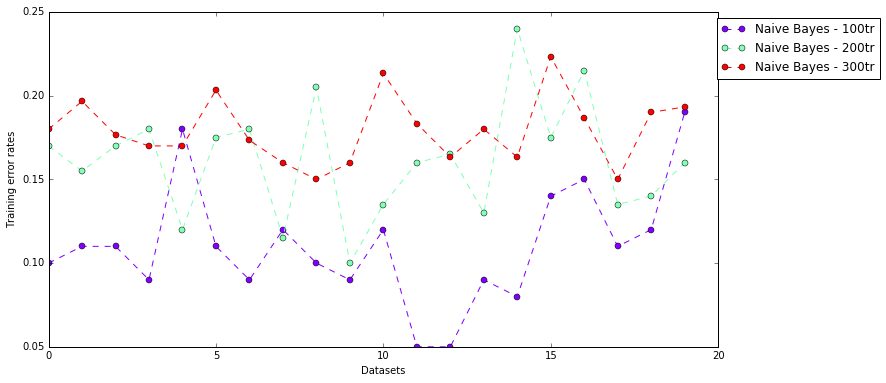

In [13]:
errors = [nb100_tr_err, nb200_tr_err, nb300_tr_err]
labels = ['Naive Bayes - 100tr', 'Naive Bayes - 200tr', 'Naive Bayes - 300tr']
comparative_plot(errors, labels, err_type='Training')

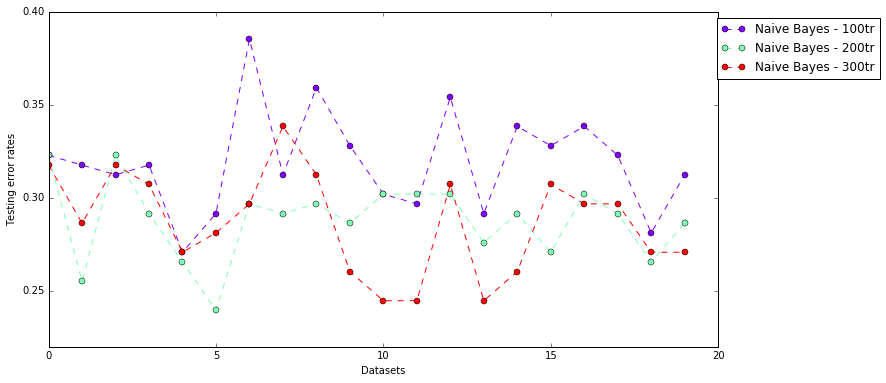

In [14]:
errors = [nb100_ts_err, nb200_ts_err, nb300_ts_err]
labels = ['Naive Bayes - 100tr', 'Naive Bayes - 200tr', 'Naive Bayes - 300tr']
comparative_plot(errors, labels, err_type='Testing')

Acerca de los resultados:

- Se ve claramente que a medida que la cantidad de datos de entrenamiento  aumenta, el error de entrenamiento lo hace en la misma medida. Sin embargo en testing set ocurre lo contrario, pues en este el error rate tiende a disminuir según la cantidad de datos aumenta.  
- Lo anterior refleja la buena capacidad de generalización que tiene Naive Bayes para este problema, y que esta capacidad aumenta a medida que la cantidad de datos de entrenamiento aumenta.

### Dual Perceptron

In [35]:
dp_params = {'eta':np.linspace(0.001,0.1,5,endpoint=True), 'gamma':np.linspace(0.5,10.,5,endpoint=True)}

In [36]:
dp = DP()
dp100_tr_err, dp100_ts_err = solve_clf(dp, 'diabetes', ntr_data=100, params=dp_params, data_func=normalize, show=[])
dp200_tr_err, dp200_ts_err = solve_clf(dp, 'diabetes', ntr_data=200, params=dp_params, data_func=normalize, show=[])
dp300_tr_err, dp300_ts_err = solve_clf(dp, 'diabetes', ntr_data=300, params=dp_params, data_func=normalize, show=[])

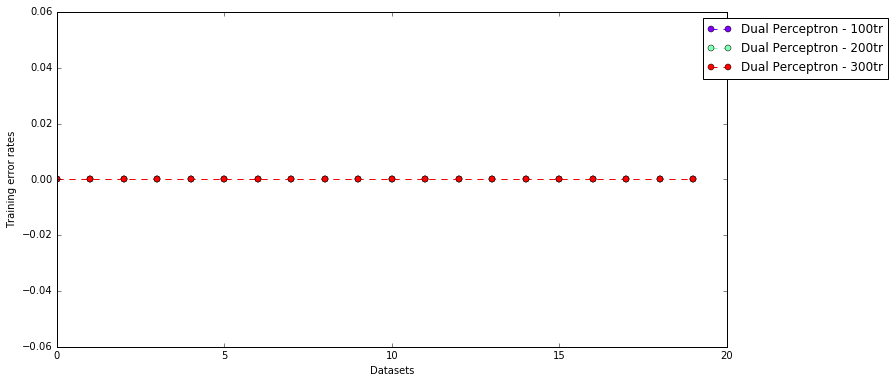

In [37]:
errors = [dp100_tr_err, dp200_tr_err, dp300_tr_err]
labels = ['Dual Perceptron - 100tr', 'Dual Perceptron - 200tr', 'Dual Perceptron - 300tr']
comparative_plot(errors, labels, err_type='Training')

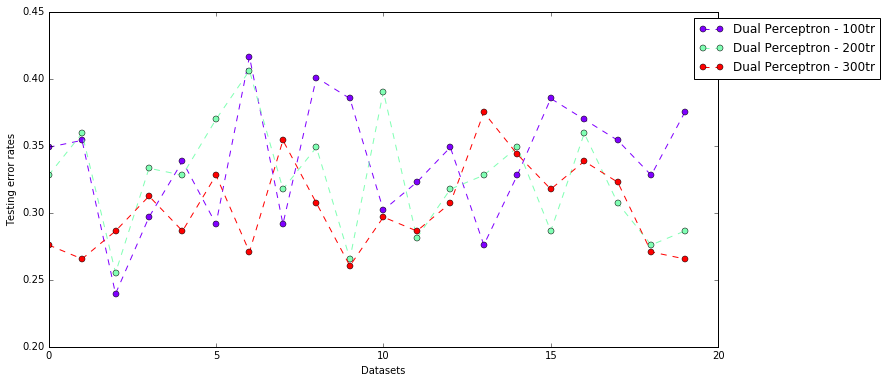

In [38]:
errors = [dp100_ts_err, dp200_ts_err, dp300_ts_err]
labels = ['Dual Perceptron - 100tr', 'Dual Perceptron - 200tr', 'Dual Perceptron - 300tr']
comparative_plot(errors, labels, err_type='Testing')

Acerca de los resultados:

- El error de training sigue siendo nulo sin importar la cantidad de data de entrenamiento.
- Los errores de testing son todos altos producto del overfitting, sin embargo se notan leves mejoras a medida que aumenta la cantidad de datos de entrenamiento.

### Kernel Nu-SVM

In [26]:
ksvm_params = {'nu':np.array([0.1, 0.2, 0.3, 0.4, 0.5]), 'gamma':np.linspace(0.5,2.,5,endpoint=True)}

In [27]:
ksvm = svm.NuSVC(kernel='rbf')
ksvm100_tr_err, ksvm100_ts_err = solve_clf(ksvm, 'diabetes', ntr_data=100, params=ksvm_params, data_func=normalize, show=[])
ksvm200_tr_err, ksvm200_ts_err = solve_clf(ksvm, 'diabetes', ntr_data=200, params=ksvm_params, data_func=normalize, show=[])
ksvm300_tr_err, ksvm300_ts_err = solve_clf(ksvm, 'diabetes', ntr_data=300, params=ksvm_params, data_func=normalize, show=[])

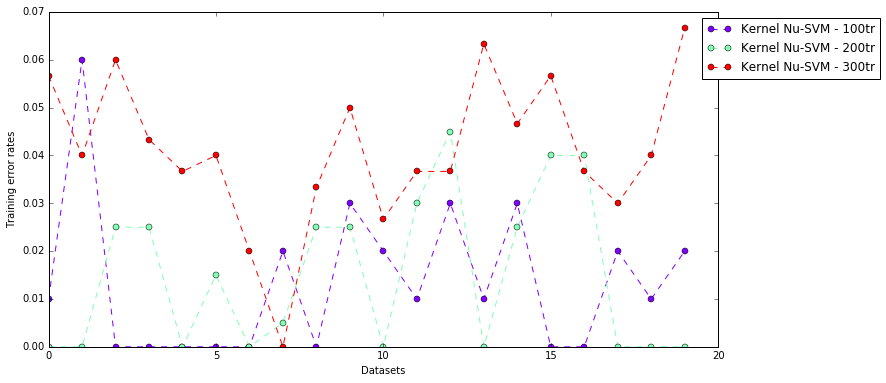

In [28]:
errors = [ksvm100_tr_err, ksvm200_tr_err, ksvm300_tr_err]
labels = ['Kernel Nu-SVM - 100tr', 'Kernel Nu-SVM - 200tr', 'Kernel Nu-SVM - 300tr']
comparative_plot(errors, labels, err_type='Training')

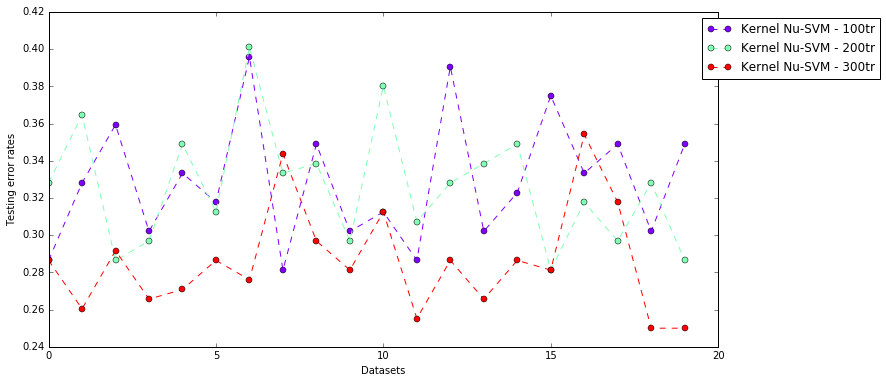

In [29]:
errors = [ksvm100_ts_err, ksvm200_ts_err, ksvm300_ts_err]
labels = ['Kernel Nu-SVM - 100tr', 'Kernel Nu-SVM - 200tr', 'Kernel Nu-SVM - 300tr']
comparative_plot(errors, labels, err_type='Testing')

Acerca de los resultados:

- De los resultados en el training set, se ve que con pocos datos se tiende al sobreajuste (error rate nulo), y de manera natural errores de testing muy altos.
- A medida que la cantidad de data de entrenamiento aumenta los resultados se estabilizan; el error de entrenamiento crece (desaparece el overfitting) y el error de testing baja en forma considerable.
- Este comportamiento refleja el hecho de que los modelos con una alta complejidad como estos, requieren de una alta cantidad de datos para obtener buenos resultados.

## Anexo de Código

**Observación:** Para la correcta ejecución del código en el informe, primero se deben ejecutar las celdas del anexo de código aquí abajo.

### Configuración del notebook

In [2]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_validation import KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.grid_search import GridSearchCV

#setting some paths
path1 = './credit/'
#data directory
path2 = './diabetes/'

### Funciones para el manejo de la data

In [3]:
#Rescale features of M to [a,b] range
def rescale(M, a=0., b=1.):
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

#Normalize features of M
def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

## Métricas de error para clasificación

In [4]:
#precision
def precision(yreal, ypred):
    yr = yreal.astype(int)
    yp = ypred.astype(int)
    m, = yr.shape
    #number of good predictions/number of predictions
    return np.sum(yp==yr)/np.float(m)

#error rate 
def error_rate(yreal, ypred):
    return 1.-precision(yreal, ypred)

## Implementación de LDA

In [5]:
class LDA(BaseEstimator,ClassifierMixin):
    def __init__(self, alternative=False):
        self.alternative = alternative
    
    def fit(self, X, y):
        #boolean masks
        mask1 = y.astype(bool)
        mask0 = np.logical_not(mask1)
        #number of samples in each class
        M,N = X.shape
        M0 = np.sum(mask0)
        #estimates of probabilities
        p0 = M0/np.float(M)
        p1 = 1-p0
        #separating data by classes
        X0 = X[mask0]
        X1 = X[mask1]
        #estimates of means by traditional way
        if not self.alternative:
            u0 = np.mean(X0, axis=0)
            u1 = np.mean(X1, axis=0)
        #estimates of means by percentile method
        elif self.alternative:
            pinf0, psup0 = np.percentile(X0, [10 ,90], axis=0)
            pinf1, psup1 = np.percentile(X1, [10, 90], axis=0)
            #percentile mask arrays
            pmask0 = (pinf0 <= X0) & (X0 <= psup0)
            pmask1 = (pinf1 <= X1) & (X1 <= psup1)
            #means computation
            u0 = np.empty(N)
            u1 = np.empty(N)
            for j in xrange(N):
                u0[j] = np.mean(X0[:,j][pmask0[:,j]])
                u1[j] = np.mean(X1[:,j][pmask1[:,j]])
        #estimation of shared covariance matrix
        Y = X.copy()
        Y[mask0] -= u0
        Y[mask1] -= u1
        Cov = np.dot(Y.T,Y)
        Cov /= (M-2.)
        #computing parameters of linear discriminants
        self.w0 = np.linalg.solve(Cov,u0)
        self.b0 = np.log(p0) - 0.5*np.dot(u0, self.w0)
        self.w1 = np.linalg.solve(Cov,u1)
        self.b1 = np.log(p1) - 0.5*np.dot(u1, self.w1)
        return self
    
    def predict(self, X):
        #evaluation of discriminant hyperplane
        return (np.dot(X,self.w1-self.w0) > self.b0-self.b1)

## Implementación de Naive Bayes

In [6]:
class NB(BaseEstimator,ClassifierMixin):
    def __init__(self, disc_type='EWD', nbins=10, features=None):
        self.disc_type = disc_type
        self.nbins = nbins
        self.features = features
        
    #equal width discretization
    def EWD(self, x):
        #interval extremes tolerance on discretization
        eps = 1e-10
        bins =  np.linspace(x.min()-eps, x.max()+eps, self.nbins+1, endpoint=True)
        return bins
    
    #equal frequency discretization
    def EFD(self, x):
        #interval extremes tolerance on discretization
        eps = 1e-10
        #sort the array
        x = np.sort(x)
        M, = x.shape
        #frequency in each resulting bin
        freq = M/self.nbins
        bins = np.empty(self.nbins+1)
        for i in range(1,self.nbins):
            bins[i] = x[i*freq]
        bins[0] = x[0]-eps
        bins[-1] = x[-1]+eps
        return bins
    
    #Gauss distribution
    def gauss(self, x, mu, sigma):
        a = (1./np.sqrt(2*np.pi*sigma**2))
        return a*np.exp(-1*(x-mu)**2/(2*sigma**2))
    
    def fit(self, X, y):
        #boolean masks
        mask1 = y.astype(bool)
        mask0 = np.logical_not(mask1)
        #number of samples in each class
        M,N = X.shape
        M0 = np.sum(mask0)
        M1 = M-M0
        #estimates of probabilities
        p0 = M0/np.float(M)
        p1 = 1-p0
        #separating data by classes
        X0 = X[mask0]
        X1 = X[mask1]
        
        #computing means and std for gauss discretization
        if self.disc_type=='Gauss':
            self.mu0 = np.mean(X0, axis=0)
            self.mu1 = np.mean(X1, axis=0)
            self.sigma0 = np.std(X0, axis=0)
            self.sigma1 = np.std(X1, axis=0)
        
        #conditional probabilities of features in each class
        CP0 = list()
        CP1 = list()
        #matrix of bins for each non-discrete feature
        B0 = np.empty((len(self.features),self.nbins+1))
        B1 = np.empty((len(self.features),self.nbins+1))
        #index of bins matrices
        ind = 0
        
        #computing conditional probabilities of features
        for f in xrange(N):
            #discretization needed
            if (f in self.features) and (self.disc_type in ['EWD','EFD']):
                f0 = X0[:,f]
                f1 = X1[:,f]
                if self.disc_type=='EWD':   bins0 = self.EWD(f0); bins1 = self.EWD(f1)
                elif self.disc_type=='EFD': bins0 = self.EFD(f0); bins1 = self.EFD(f1)
                frec0 = np.bincount(np.digitize(f0, bins0), minlength=self.nbins+2) + 1.
                frec1 = np.bincount(np.digitize(f1, bins1), minlength=self.nbins+2) + 1.
                CP0.append(frec0/(M0+self.nbins+2))
                CP1.append(frec1/(M1+self.nbins+2))
                B0[ind] = bins0
                B1[ind] = bins1
                ind += 1
            #no discretization needed
            else:
                f0 = X0[:,f].astype(int)
                f1 = X1[:,f].astype(int)
                frec0 = np.bincount(f0, minlength=np.max(f0)+1) + 1.
                frec1 = np.bincount(f1, minlength=np.max(f1)+1) + 1.
                CP0.append(frec0/(M0+np.max(f0)+1))
                CP1.append(frec1/(M1+np.max(f1)+1))        
        #storing needed data
        self.p0 = p0
        self.p1 = p1 
        self.CP0 = CP0
        self.CP1 = CP1
        self.B0 = B0
        self.B1 = B1
        return self
        
    def predict(self, X):
        M,N = X.shape
        prob0 = np.ones(M)
        prob1 = np.ones(M)
        #index of bins matrices
        ind1 = 0
        #index of CP, for gauss case
        ind2 = 0
        for f in xrange(N):
            #discretization needed
            if (f in self.features) and (self.disc_type in ['EWD','EFD']):
                tmp = X[:,f]
                tmp0 = np.digitize(tmp, self.B0[ind1]).astype(int)
                tmp1 = np.digitize(tmp, self.B1[ind1]).astype(int)
                prob0 *= (self.CP0[f])[tmp0]
                prob1 *= (self.CP1[f])[tmp1]
                ind1 +=1
            elif (f in self.features) and (self.disc_type in ['Gauss']):
                prob0 *= self.gauss(X[:,f], self.mu0[f], self.sigma0[f])
                prob1 *= self.gauss(X[:,f], self.mu1[f], self.sigma1[f])
                
            #no discretization needed
            elif (self.disc_type in ['EWD','EFD']):
                tmp = X[:,f].astype(int)
                prob0 *= (self.CP0[f])[tmp]
                prob1 *= (self.CP1[f])[tmp]
            elif (self.disc_type in ['Gauss']):
                tmp = X[:,f].astype(int)
                prob0 *= (self.CP0[ind2])[tmp]
                prob1 *= (self.CP1[ind2])[tmp]
                ind2 += 1
        prob0 *= self.p0
        prob1 *= self.p1
        return (prob0 < prob1).astype(int)
    
    #to make it compatible with scikit
    def score(self, X, y):
        return precision(y, self.predict(X))

## Implementación de Primal Perceptron

In [7]:
class PP(BaseEstimator,ClassifierMixin):
    def __init__(self, eta=0.01, n_iter=100000, tol=20):
        self.eta = eta
        self.n_iter = n_iter
        self.tol = tol
    
    def f(self, X):
        return np.dot(X,self.w)+self.b
    
    def fit(self, X, y):
        M,N = X.shape
        #initial guesses
        self.w = np.zeros(N)
        self.b = 0.
        #R parameter
        R = np.max(np.linalg.norm(X, axis=1))
        #error rate and counter
        err1 = error_rate(y, self.predict(X))
        c = 0
        
        for i in xrange(self.n_iter):
            #error rate at previous iteration
            err0 = err1
            for m in xrange(M):
                #if misclassified
                if y[m]*self.f(X[m])<=0:
                    self.w += self.eta*y[m]*X[m]
                    self.b += self.eta*y[m]*R**2
            err1 = error_rate(y, self.predict(X))
            #stopping criterions
            if err1==0.: break
            elif err0==err1:
                c += 1
                if c > self.tol: break
            else: c = 0
        #store the number of iterations needed
        self.it = i+1
        return self
        
    def predict(self, X):
        return np.sign(self.f(X))
    
    #to make it compatible with scikit
    def score(self, X, y):
        return precision(y, self.predict(X))

## Implementación de Dual Perceptron

In [8]:
class DP(BaseEstimator,ClassifierMixin):
    def __init__(self, eta=0.01, gamma=0.5, n_iter=100000, tol=20):
        self.eta = eta
        self.gamma = gamma
        self.n_iter = n_iter
        self.tol = tol
        pass

    def fit(self, X, y):
        M,N = X.shape
        #store data
        self.X = X
        self.y = y
        #initial guesses
        self.alp = np.zeros(M)
        self.b = 0.
        #R parameter
        R = np.max(np.linalg.norm(X, axis=1))
        #precomputed kernel matrix
        self.K = rbf_kernel(X, gamma=self.gamma)
        #error rate and counter
        err1 = error_rate(y, self.predict(X))
        c = 0
        
        for i in xrange(self.n_iter):
            #error rate at previous iteration
            err0 = err1
            for m in xrange(M):
                #if misclassified
                if y[m]*(np.sum(self.alp*y*self.K[m])+self.b)<=0:
                    self.alp[m] += 1
                    self.b += self.eta*y[m]*R**2
            err1 = error_rate(y, self.predict(X))
            #stopping criterions
            if err1==0.: break
            elif err0==err1:
                c += 1
                if c > self.tol: break
            else: c = 0
        #store the number of iterations needed
        self.it = i+1
        return self
        
    def predict(self, X):
        if np.array_equal(X, self.X):
            K = self.K
        else:
            #compute the kernel matrix
            K = rbf_kernel(X, self.X, self.gamma)
        f = np.sum(self.alp*self.y*K, axis=1)+self.b
        return np.sign(f)
    
    #to make it compatible with GridSearch
    def score(self, X, y):
        return precision(y, self.predict(X))

## Funciones complementarias (helpers) para obtener resultados

In [9]:
"""
Function to generate histogram of winners
"""
def make_hist(winners,params):
    for key in winners:
        par = params[key]
        win = np.array(winners[key])
        freqs = np.zeros(5)
        for i in xrange(5):
            freqs[i] = np.sum(par[i]==win)
        labels = map(str,par)
        pos = np.arange(len(labels))
        width = 1.0
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(5)
        ax = plt.axes()
        ax.set_xticks(pos + (width / 2))
        ax.set_xticklabels(labels)
        plt.xlabel('Parameters')
        plt.ylabel('Frequency')
        plt.title('Histogram of {0}'.format(key))
        plt.bar(pos, freqs, width, color='0.5')
        plt.show()
    
def plot_error(tr_err, ts_err):
    x = np.arange(20)
    plt.figure(figsize=(12,6))
    plt.plot(x, tr_err, marker='o', linestyle='--', color='b', label='Training Error')
    plt.plot(x, ts_err, marker='o', linestyle='--', color='r', label='Testing Error')
    plt.xlabel('Datasets')
    plt.ylabel('Error Rate')
    plt.title('Training and testing error rates in each dataset')
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.show()
    
    
def comparative_plot(errors, labels, err_type=None):
    x = np.arange(20)
    colors = cm.rainbow(np.linspace(0., 1., len(errors)))
    plt.figure(figsize=(12,6))
    for i in xrange(len(errors)):
        plt.plot(x, errors[i], marker='o', linestyle='--', color=colors[i], label=labels[i])
    plt.xlabel('Datasets')
    plt.ylabel(err_type+' error rates')
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.show()
    

"""
Generate solutions for classification problems
"""
def solve_clf(clf, dataset, params=None, grid=None, ntr_data=None, data_func=None, show=None):
    if params is not None:
        winners = dict()
        for key in params:
            winners[key] = list()
            
    #set dataset name
    if dataset=='credit':
        path = './credit/credit'
    elif dataset=='diabetes':
        path = './diabetes/diabetes'
    else: return -1
    
    #error rates to plot
    tr_err = np.empty(20)
    ts_err = np.empty(20)
    
    #iterate through data
    for i in xrange(20):
        #loading datasets
        if ntr_data is not None:
            tr_file = path+'-tr-{0}-{1}.npy'.format(i, ntr_data)
        else:
            tr_file = path+'-tr-{0}.npy'.format(i)
        ts_file = path+'-ts-{0}.npy'.format(i)
            
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
            X_ts = ts_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        if (type(clf) is PP) or (type(clf) is DP) or (type(clf) is svm.NuSVC):
            #change label for separating hyperplanes approaches
            y_tr[y_tr==0.] = -1
            y_ts[y_ts==0. ]= -1

        if params is not None:
            #tunning parameters
            gs = GridSearchCV(clf, params, cv=5, n_jobs=2)
            gs.fit(X_tr, y_tr)
            grid_scores = gs.grid_scores_
            best_params = gs.best_params_
            for key in winners:
                winners[key].append(best_params[key])
            #traininig with best parameters
            clf.set_params(**best_params)
            clf.fit(X_tr, y_tr)
        else:
            clf.fit(X_tr, y_tr)
        
        #computing errors
        tr_err[i] = error_rate(y_tr, clf.predict(X_tr))
        ts_err[i] = error_rate(y_ts, clf.predict(X_ts))
        
        if (show is not None) and (i not in show): continue
        print "##############################################################"
        print "Dataset: {0}".format(i)
        if params is not None:
            print 'Best parameter: {0}'.format(best_params)
            print 'CV scores:'
            for result in grid_scores: print result
        print 'Training error: {0}'.format(tr_err[i])
        print 'Testing error: {0}'.format(ts_err[i])
        print "##############################################################"
        print '\n'
    
    #ploting errors
    if show: 
        plot_error(tr_err, ts_err)
        if params is not None: make_hist(winners, params)
    return (tr_err,ts_err)